In [39]:
# Install AIF360 (if running locally)
# !pip install aif360 pandas matplotlib numpy

import pandas as pd
import matplotlib.pyplot as plt
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing


In [30]:
# -----------------------------
# 1. Load CSV
# -----------------------------
url = "/home/cleiton-langa/Documents/PLP_Lessons/AiForSoftwareEngineer/week-7/data/compas-scores.csv"
df = pd.read_csv(url)

In [31]:
# -----------------------------
# 2. Keep only necessary columns
# -----------------------------
df = df[['is_recid', 'race']].dropna()  # remove rows with missing values

In [ ]:
# -----------------------------
# 3. Rename columns and convert types
# -----------------------------
df = df.rename(columns={'is_recid': 'two_year_recid'})
df['two_year_recid'] = df['two_year_recid'].astype(int)


In [33]:

# Convert race to binary: privileged = Caucasian → 1, unprivileged = African-American → 0
# Drop "Other" since it may cause group size issues
df = df[df['race'].isin(['Caucasian', 'African-American'])]
df['race'] = df['race'].apply(lambda x: 1 if x == 'Caucasian' else 0)

In [35]:
# Convert is_recid to binary 0/1 for AIF360
# 0 = no recidivism (favorable)
# 1 = recidivism (unfavorable)
df['two_year_recid'] = df['two_year_recid'].apply(lambda x: 0 if x == 0 else 1)

# -----------------------------
# 4. Load dataset into AIF360
# -----------------------------
dataset = BinaryLabelDataset(
    df=df[['two_year_recid','race']],
    label_names=['two_year_recid'],
    protected_attribute_names=['race'],
    favorable_label=0,  # no recidivism
    unfavorable_label=1 # recidivism
)


In [36]:
# -----------------------------
# 5. Check group counts (important to avoid NaN metrics)
# -----------------------------
def group_summary(dataset, group_attr, label_name):
    df_check = dataset.convert_to_dataframe()[0]
    for val in [0, 1]:
        for lbl in [0, 1]:
            count = len(df_check[(df_check[group_attr] == val) & (df_check[label_name] == lbl)])
            print(f"group={val}, label={lbl}, count={count}")

group_summary(dataset, 'race', 'two_year_recid')

group=0, label=0, count=3326
group=0, label=1, count=2487
group=1, label=0, count=2729
group=1, label=1, count=1356


In [37]:
# -----------------------------
# 6. Apply Reweighing
# -----------------------------
privileged = [{'race': 1}]
unprivileged = [{'race': 0}]

rw = Reweighing(unprivileged_groups=unprivileged, privileged_groups=privileged)
dataset_transf = rw.fit_transform(dataset)

In [40]:
# -----------------------------
# 7. Compute fairness metrics
# -----------------------------
metric_orig = BinaryLabelDatasetMetric(dataset,
                                       privileged_groups=privileged,
                                       unprivileged_groups=unprivileged)

metric_rw = BinaryLabelDatasetMetric(dataset_transf,
                                     privileged_groups=privileged,
                                     unprivileged_groups=unprivileged)

disparate_impact = [metric_orig.disparate_impact(), metric_rw.disparate_impact()]
mean_diff = [metric_orig.mean_difference(), metric_rw.mean_difference()]

print("Before Reweighing:")
print("Disparate Impact:", metric_orig.disparate_impact())
print("Mean difference (privileged - unprivileged):", metric_orig.mean_difference())

print("\nAfter Reweighing:")
print("Disparate Impact:", metric_rw.disparate_impact())
print("Mean difference (privileged - unprivileged):", metric_rw.mean_difference())

Before Reweighing:
Disparate Impact: 0.8564666312860505
Mean difference (privileged - unprivileged): -0.09588802037218314

After Reweighing:
Disparate Impact: 0.9999999999999997
Mean difference (privileged - unprivileged): -2.220446049250313e-16


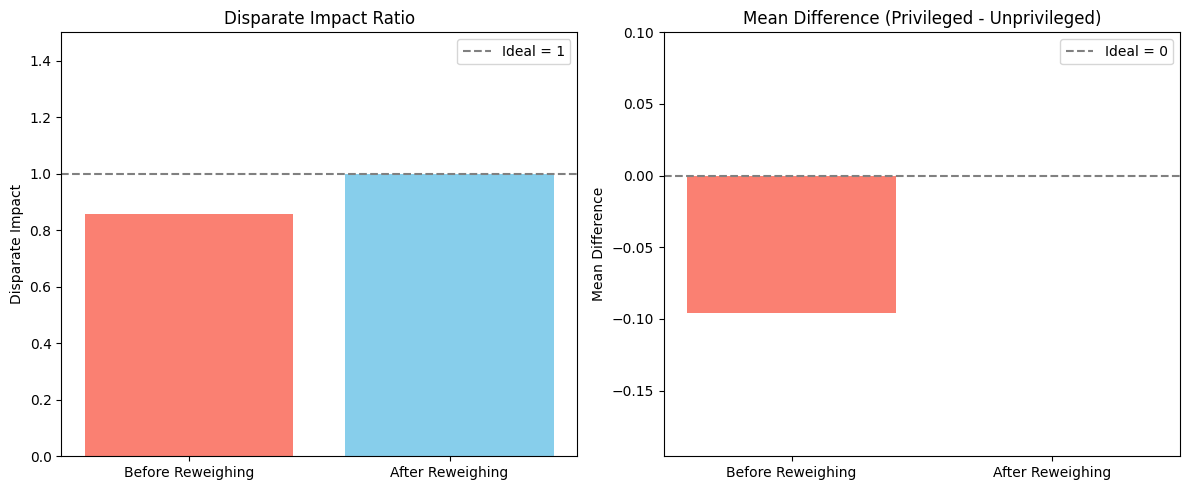

In [41]:
# -----------------------------
# 8. Visualize metrics
# -----------------------------
labels = ['Before Reweighing', 'After Reweighing']

fig, ax = plt.subplots(1, 2, figsize=(12,5))

# Disparate Impact plot
ax[0].bar(labels, disparate_impact, color=['salmon','skyblue'])
ax[0].set_ylim(0, max(disparate_impact)+0.5)
ax[0].set_title('Disparate Impact Ratio')
ax[0].set_ylabel('Disparate Impact')
ax[0].axhline(1, color='gray', linestyle='--', label='Ideal = 1')
ax[0].legend()

# Mean Difference plot
ax[1].bar(labels, mean_diff, color=['salmon','skyblue'])
ax[1].set_ylim(min(mean_diff)-0.1, max(mean_diff)+0.1)
ax[1].set_title('Mean Difference (Privileged - Unprivileged)')
ax[1].set_ylabel('Mean Difference')
ax[1].axhline(0, color='gray', linestyle='--', label='Ideal = 0')
ax[1].legend()

plt.tight_layout()
plt.show()